# Train a hornet classifier
We train a deep neurel network to classify our extracted images of hornets.

In [1]:
import os
import sys
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Magic: automatically reload imports + inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Experiment name
exp_name = 'resnet18-lrp'

# Root directory
drive.mount('/content/gdrive', force_remount=True)  # Mount Google Drive
root_dir = '/content/gdrive/MyDrive/Projects/vespai'
sys.path.insert(0, root_dir)
os.chdir(root_dir)
data_dir = os.path.join(root_dir, 'datasets/extracts-21')
weights_dir = os.path.join(
    root_dir, 'models/classifier-runs/' + exp_name + '/weights',
)
os.makedirs(weights_dir, exist_ok=True)

# Save figures
save_ok = True
fig_dir = os.path.join(root_dir, 'models/classifier-runs/' + exp_name + '/figs')
os.makedirs(fig_dir, exist_ok=True)

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
   print(gpu_info)

# RAM availability
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mounted at /content/gdrive
Device:  cuda:0
Wed Aug 31 10:15:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                             

## Load and prepare the data

In [2]:
import glob

# Locate data
train_files = glob.glob(os.path.join(data_dir, 'train/*.jpeg'))
val_files = glob.glob(os.path.join(data_dir, 'val/*.jpeg'))
test_files = glob.glob(os.path.join(data_dir, 'test/*.jpeg'))

Class:  0
Class name:  Vespa crabro


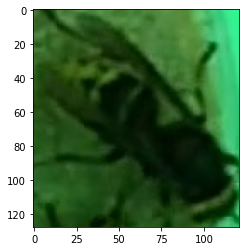

In [3]:
# Class names
class_dict = {
     0: 'Vespa crabro',
     1: 'Vespa velutina',
     2: 'Other',
}

# Plot example
rand_file = train_files[np.random.randint(len(train_files), size=1)[0]]
rand_image = cv2.imread(os.path.join(rand_file))  # image.shape = (h, w, c)
rand_image = cv2.cvtColor(rand_image, cv2.COLOR_BGR2RGB)
print('Class: ', int(rand_file[-6]))
print('Class name: ', class_dict[int(rand_file[-6])])

plt.imshow(rand_image)
plt.show()

### Torch datasets
Unaugmented example using `HornetDataset` class. From this example below we note that the images need preprocessing to have the same shape and normalisation.

Image shape:  (169, 119, 3)
Image class: Vespa velutina


Image shape:  (168, 162, 3)
Image class: Vespa velutina


Image shape:  (153, 134, 3)
Image class: Vespa velutina


Image shape:  (94, 167, 3)
Image class: Vespa velutina




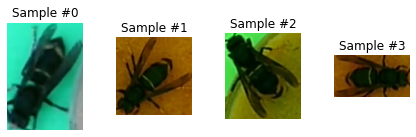

In [4]:
from models.classifier.loader import HornetDataset

example_set = HornetDataset(train_files)

fig = plt.figure()
for i in range(len(example_set)):
    image, target = example_set[i]
    print('Image shape: ', image.shape) 
    print('Image class: {}'.format(class_dict[int(target[1])]))
    print('\n')
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

Demonstrate the use of transformations to augment images.

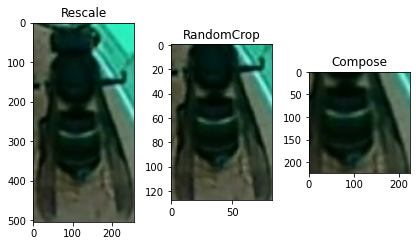

In [5]:
from models.classifier.loader import Rescale, RandomCrop
from torchvision import transforms

scale = Rescale(256)
crop = RandomCrop(128)
both = transforms.Compose([Rescale(256), RandomCrop(224)])

# Apply each of the above transforms on sample.
sample = example_set[65]
fig = plt.figure()
for i, aug in enumerate([scale, crop, both]):
    aug_sample = aug(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(aug).__name__)
    plt.imshow(aug_sample[0])

plt.show()

### Construct dataloaders

Batch number  0 , batch size:  torch.Size([64, 3, 256, 256])
Batch number  1 , batch size:  torch.Size([64, 3, 256, 256])
Batch number  2 , batch size:  torch.Size([64, 3, 256, 256])
Batch number  3 , batch size:  torch.Size([64, 3, 256, 256])


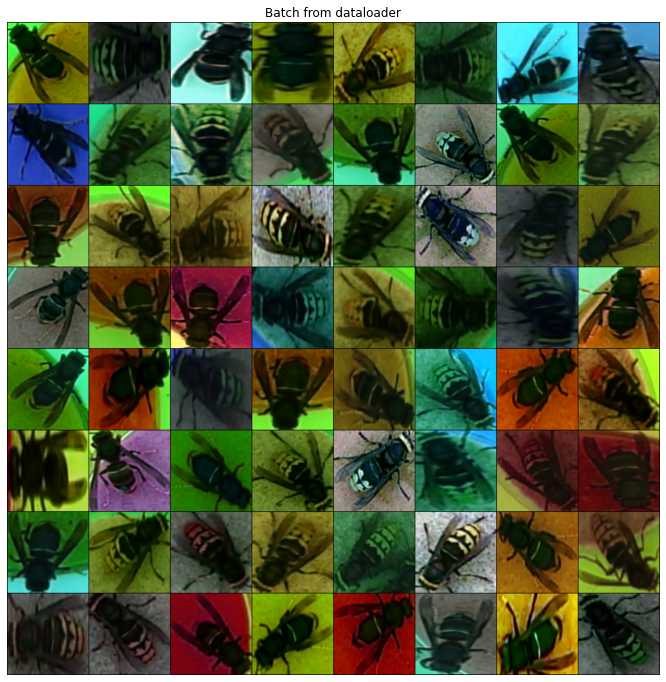

In [6]:
from models.classifier.loader import get_hornet_loader
from models.classifier.utils import show_batch

# Get data loaders
train_loader = get_hornet_loader(train_files, batch_size=64, augment=True)
val_loader = get_hornet_loader(val_files, batch_size=1, augment=False)

# Print samples of batches
for idx, sample_batch in enumerate(train_loader):
    print('Batch number ', idx, ', batch size: ', sample_batch[0].size())

    # Observe 4th batch and stop.
    if idx == 3:
        plt.figure(figsize=(12, 12))
        show_batch(sample_batch)
        plt.axis('off')
        plt.ioff()
        plt.savefig(os.path.join(fig_dir, 'augs.png'))
        plt.show()
        break



## Training a classifier network
We first define a model to classify into either Vespa crabro or Vespa velutina. We don't use `nn.Softmax()` as we seperate binary classifications into the above two classes (one-against-rest) in order to account for examples outside those classes. Probabilities are obtained with the logistic sigmoids `nn.Sigmoid()`. To complement this choice we apply Binary Cross-Entropy loss to the outputs.

In [7]:
%%script false --no-raise-error

import torch.nn as nn
import torch.nn.functional as F


class BasicNet(nn.Module):
    """Basic convolutional classifier network."""
    
    def __init__(self, num_classes=2):
        super(BasicNet, self).__init__()
        self.norm8 = nn.BatchNorm2d(8)
        self.norm16 = nn.BatchNorm2d(16)
        self.norm32 = nn.BatchNorm2d(32)
        self.conv1 = nn.Conv2d(3, 8, 5, 2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5, 2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5, 2, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        """Forward function expects x.shape = (N, 3, 256, 256)."""
        x = self.conv1(x)  # x.shape = (N, 8, 128, 128)
        x = F.relu(self.norm8(x))
        x = self.conv2(x)  # x.shape = (N, 16, 64, 64)
        x = F.relu(self.norm16(x))
        x = self.pool(x)  # x.shape = (N, 16, 32, 32)
        x = self.conv3(x)  # x.shape = (N, 32, 16, 16)
        x = F.relu(self.norm32(x))
        x = self.pool(x)  # x.shape = (N, 32, 8, 8)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.final_activation(x)


In [8]:
# Import model from lrp-resnet
sys.path.insert(0, os.path.join(root_dir, 'explanation/lrp-resnet/notebooks'))
from resnet import resnet18

# Or directly from torchvision
# from torchvision.models import resnet18

# Instantiate model
model = resnet18(num_classes=2)
model.eval()

# Save location
last_weights = os.path.join(weights_dir, 'last.pt')
best_weights = os.path.join(weights_dir, 'best.pt')

# Train from previous best weights
resume_weights = False
if os.path.exists(best_weights) and resume_weights:
    model.load_state_dict(torch.load(best_weights))

In [9]:
%%script false --no-raise-error

# Print model's state_dict
print("* Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
    
print('\n')

# Print optimizer's state_dict
print("* Optimiser's state_dict:")
for var_name in optimiser.state_dict():
    print(var_name, "\t", optimiser.state_dict()[var_name])

# print(model)

### Training routine

In [ ]:
import time
from tqdm.notebook import tqdm
from models.classifier.utils import accuracy

num_epochs = 200
epoch_progress_cut_off = 25
learning_rate = 0.001
test_threshold = 0.8
best_epoch = 0

thresholds = torch.linspace(0.5, 0.95, 10)
assert any(thresholds == test_threshold)

# Loss function: BCE loss (needs sigmoid activation input)
criterion = torch.nn.BCELoss()

# Activation
activation = torch.nn.Sigmoid()

# Optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Record statistics
sub_stats = 5
batch_freq = int(len(train_loader) / sub_stats)  # To print sub-epoch stats
epoch_freq = 1  # Number of epochs on which to validate model
train_loss, val_loss, train_acc, val_acc = [], [], [], []

# Training mode
model.train()

# Iterate training proceedure
for epoch in tqdm(range(num_epochs)):

    print('\nEpoch {:02d}\n--------'.format(epoch))
    start_time = time.time()
    t0 = start_time

    # Accumulated loss in given epoch
    running_loss = 0.0
    for batch, data in enumerate(train_loader, start=0):
        
        # Perform optimisation step
        images, labels = data  # Retrieve batch data
        optimiser.zero_grad()  # Zero parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(activation(outputs), labels)  # Compute loss
        loss.backward()  # Backpropagate
        optimiser.step()  # Update gradients
        running_loss += loss.item()  # Record loss

        if batch % batch_freq == 0:

            # Training loss
            if not batch == 0:
                running_loss /= batch_freq
            train_loss.append(running_loss)
            print('Batch {:02d} | Training loss {:00.4f} | Running time {:.2f}s'
                  .format(batch, running_loss, time.time() - t0)
                  )
            t0 = time.time()
            running_loss = 0.0
    
    if epoch % epoch_freq == 0:

        # Evaluation mode
        model.eval()
        
        # Validation loss
        running_loss = 0.0
        for image, target in val_loader:
            with torch.no_grad():
                logits = model(image)
                running_loss += criterion(activation(logits), target).item()
        val_loss.append(running_loss / len(val_loader))

        # Validation and trianing accuracy
        th_ind = (thresholds == test_threshold)
        val_acc.append(float(accuracy(model, activation, val_loader)[th_ind]))

        print('\nSummary:\n'
              '\tValidation acc: {:.2%} (at an {:.0%} threshold) \n'
              '\tValidation loss: {:.4f}\n'
              '\tEpoch running time: {:.2f}s'
              .format(val_acc[-1], test_threshold,
                      val_loss[-1],
                      time.time() - start_time,
                      )
        )
        
        # Save last weights
        print(f'Saving `last` model weights at epoch {epoch}')
        torch.save(model.state_dict(), last_weights)

        # Save best weights wrt accuracy
        if epoch == 0 or all(loss > val_loss[-1] for loss in val_loss[:-1]):
            print(f'* Saving `best` model weights at epoch {epoch} *\n')
            torch.save(model.state_dict(), best_weights)
            best_epoch = epoch
        else:
            print(f'Previous `best` weights recorded at epoch {best_epoch}\n')

        if epoch - best_epoch >= epoch_progress_cut_off:
            print(f'Final epoch before terminating training: {epoch}')
            num_epochs = epoch + 1
            break

print(f'Finished Training. Best validation loss at epoch: {best_epoch}')

  0%|          | 0/200 [00:00<?, ?it/s]


Epoch 00
--------
Batch 00 | Training loss 0.6691 | Running time 6.57s
Batch 05 | Training loss 0.7780 | Running time 34.02s
Batch 10 | Training loss 0.4984 | Running time 32.18s
Batch 15 | Training loss 0.5014 | Running time 31.69s
Batch 20 | Training loss 0.4921 | Running time 31.59s
Batch 25 | Training loss 0.4404 | Running time 31.47s

Summary:
	Validation acc: 6.90% (at an 80% threshold) 
	Validation loss: 0.7631
	Epoch running time: 216.76s
Saving `last` model weights at epoch 0
* Saving `best` model weights at epoch 0 *


Epoch 01
--------
Batch 00 | Training loss 0.7829 | Running time 6.20s
Batch 05 | Training loss 0.7338 | Running time 30.99s
Batch 10 | Training loss 0.6529 | Running time 30.96s
Batch 15 | Training loss 0.6597 | Running time 31.43s
Batch 20 | Training loss 0.6424 | Running time 30.86s
Batch 25 | Training loss 0.5448 | Running time 30.50s

Summary:
	Validation acc: 74.57% (at an 80% threshold) 
	Validation loss: 0.4647
	Epoch running time: 209.28s
Saving `last

## Plot training session statistics

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()  # New axis for accuracy plot

# Time axis
xt = np.linspace(1, num_epochs, len(train_loss))
xv = np.linspace(1, num_epochs, int((num_epochs - 1) / epoch_freq) + 1)

# Loss & accuracy plots
tloss, = ax1.plot(xt, train_loss, color='tab:blue', label='Training loss')
vloss, = ax1.plot(
    xv, val_loss, linestyle='dotted', linewidth=3, color='tab:pink',
    label='Validation loss',
)
vacc, = ax2.plot(xv, val_acc, color='tab:green', label='Validation accuracy')

# Best epoch
yb = val_loss[int(best_epoch / epoch_freq)]
yc = val_acc[int(best_epoch / epoch_freq)]
ax1.plot(best_epoch + 1, yb, 'co', markersize=10)
#ax2.plot(best_epoch + 1, yc, 'co')
ax1.annotate('Best epoch: #{}\n Acc: {:.2%}'.format(best_epoch + 1, yc),
               (best_epoch + 1, yb),
               textcoords="offset points", # Where to position text
               xytext=(40, 100), # Distance from text to points (x,y)
               ha='center',
               )

# Axes labels
ax1.set_ylabel('BCE Loss', fontsize=14)
ax2.set_ylabel(
    'Validation acc. @ an {:.0%} threshold'.format(test_threshold), fontsize=14,
)
ax1.set_xlabel('Epoch', fontsize=14)
plt.xlim([1, num_epochs])
ax2.set_ylim(bottom=0., top=1.)
ax1.set_title('Training over {} epochs'.format(num_epochs), fontsize=17)

# Legend
fig.legend(
    [tloss, vloss, vacc],
    ['Training loss',
     'Validation loss',
     'Validation accuracy',
    ],
    loc='center',
    prop={'size': 14}
)

plt.tight_layout()
plt.show()
if save_ok:
    fig.savefig(os.path.join(fig_dir, 'stats.png'))

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(7, 8), sharex=True)

# Time axis
xt = np.linspace(1, num_epochs, len(train_loss))
xv = np.linspace(1, num_epochs, int((num_epochs - 1) / epoch_freq) + 1)

# Loss & accuracy plots
ax[0].plot(xt, train_loss, color='tab:blue', label='Training loss')
# ax[1].plot(xv, train_acc, color='tab:orange', label='Training accuracy')
ax[1].plot(
    xv, val_loss, linestyle='dotted', color='tab:pink', label='Validation loss'
)
ax[2].plot(xv, val_acc, color='tab:green', label='Validation accuracy')

# Best epoch
yb = val_loss[int(best_epoch / epoch_freq)]
yc = val_acc[int(best_epoch / epoch_freq)]
# ax[0].plot(best_epoch + 1, train_loss[int(best_epoch / epoch_freq)], 'yo')
# ax[1].plot(best_epoch + 1, train_acc[int(best_epoch / epoch_freq)], 'co')
ax[1].plot(best_epoch + 1, yb, 'co')
ax[2].plot(best_epoch + 1, yc, 'co')
ax[2].annotate('Epoch {}'.format(best_epoch + 1),
               (best_epoch + 1, yb),
               textcoords="offset points", # Where to position text
               xytext=(0, 50), # Distance from text to points (x,y)
               ha='center',
               )

# Axes labels
ax[0].set_ylabel('Training\nLoss')
# ax[1].set_ylabel('Training Acc\n@ {:.0%} threshold'.format(test_threshold))
ax[1].set_ylabel('Validation\nLoss')
ax[2].set_ylabel('ValidationAcc\n@ {:.0%} threshold'.format(test_threshold))
plt.xlabel('Epoch')
plt.xlim([1, num_epochs])
# ax[1].set_ylim(bottom=0., top=1.)
ax[2].set_ylim(bottom=0., top=1.)

# fig.legend()           
plt.tight_layout()
plt.show()
if save_ok:
    fig.savefig(os.path.join(fig_dir, 'split.png'))

## Compute trained model performance

In [ ]:
from models.classifier.utils import f1scores

model.load_state_dict(torch.load(best_weights))
f1, f1_thresholds = f1scores(model, activation, val_loader)

In [ ]:
from models.classifier.utils import accuracy
acc = accuracy(model, val_loader, thresholds=f1_thresholds, num_classes=2)

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

acc_line, = ax.plot(
    f1_thresholds, acc, linewidth=3, linestyle='dotted', color='tab:blue'
)
f1_line, = ax.plot(
    f1_thresholds, f1, linewidth=1, linestyle='solid', color='tab:pink'
)

ax.set_xlabel('Threshold', fontsize=15)
ax.set_title(r'$F_1$ Score and Accuracy vs. Threshold', fontsize=17)

ax.set_xlim(left=0., right=1.)
ax.set_ylim(bottom=0., top=1.)

ax.legend(
    [f1_line, acc_line],
    [r'$F_1 = \frac{2\times(Precision \times Recall)}{Precision + Recall}$',
     'Accuracy'
    ],
    loc='lower center',
    prop={'size': 14}
)

ax.grid(True)
fig.tight_layout()
plt.show()

if save_ok:
    fig.savefig(os.path.join(fig_dir, 'f1-acc.png'))

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))
f1_line = ax.plot(
    f1_thresholds, f1, linewidth=3, linestyle='solid', color='tab:pink'
)
ax.set_xlabel('Threshold', fontsize=15)
#ax.set_ylabel(
#    r'$F_1 = \frac{2\times(Precision \times Recall)}{Precision + Recall}$',
#    fontsize=18,
#)
ax.set_title(r'$F_1$ Score vs. Acceptance Threshold', fontsize=17)

ax.set_xlim(left=0., right=1.)
ax.set_ylim(bottom=0., top=1.)

ax.legend(
    f1_line,
    [r'$F_1 = \frac{2\times(Precision \times Recall)}{Precision + Recall}$',],
    loc='lower center',
    prop={'size': 18}
)

ax.grid(True)
fig.tight_layout()
plt.show()

if save_ok:
    fig.savefig(os.path.join(fig_dir, 'f1-scores.png'))